In [1]:
import os
nthreads = 10
os.environ["OMP_NUM_THREADS"] = str(nthreads) 
os.environ["OPENBLAS_NUM_THREADS"] = str(nthreads) 
os.environ["MKL_NUM_THREADS"] = str(nthreads)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
from mne import events_from_annotations
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import string

from utils.utils import *

from pycrostates.cluster import ModKMeans
from pycrostates.preprocessing import extract_gfp_peaks
from pycrostates.io import ChData, read_cluster

from pycrostates.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    dunn_score,
    davies_bouldin_score,
)

from mne.io import RawArray
from mne import Annotations

from scipy.stats import ttest_rel
from statsmodels.stats.anova import AnovaRM

import statsmodels.api as sm
import statsmodels.formula.api as smf

/home/barzon/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
### Load infos
info = load_info()
n_subj = 44
subjects = np.arange(n_subj) + 1

Reading /data/barzon/stroop/ss01_clean.fdt
Reading 0 ... 2439999  =      0.000 ...  4879.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.7s finished


In [3]:
### Load dataset
raw = load_dataset(1)

### Load events id
events, events_id = events_from_annotations(raw)
tasks = list(events_id.keys())[1:7]
tasks = ['REST']+tasks
print(tasks)

Reading /data/barzon/stroop/ss01_clean.fdt
Reading 0 ... 2439999  =      0.000 ...  4879.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


Used Annotations descriptions: ['RT', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172']
['REST', 'S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72']


[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.8s finished


In [4]:
folder_to_save = 'results_pycrostates_250_Hz/'
#folder_to_save = 'results_pycrostates/'

In [5]:
### Define global params
cluster_range = np.arange(2,11)
min_peak_distance = 10
max_peaks = int(1e4)

### Useful params
n_jobs = 10
to_save = True

In [9]:
reject_edges = True

factor = 0
half_window_size = 0
min_segment_length = 0

folder_statistics = folder_to_save + f'statistics_factor_{factor}_window_{half_window_size}_segment_{min_segment_length}/'
os.makedirs(folder_statistics, exist_ok=True)

print(folder_statistics)

results_pycrostates_250_Hz/statistics_factor_0_window_0_segment_0/


# Show cluster centers

In [116]:
reorder = [None,
           None,
           [2,3,0,1],
           [2,4,1,3,0],
           [1,3,2,5,4,0],
           [1,6,0,3,4,2,5],
           [1,3,2,0,4,5,6,7],
           None, #[3,6,1,5,8],
           None]

In [117]:
### Load group clustering
print('Loading stored group clustering...\n')
models = [read_cluster(folder_to_save+f'clustering_group_k_{n_clusters}.fif') for n_clusters in cluster_range]

# Reorder
for tmp_idx, tmp_mod in enumerate(models):
    if reorder[tmp_idx] is not None:
        tmp_mod.reorder_clusters(order=reorder[tmp_idx])
    tmp_mod.rename_clusters(new_names=list(string.ascii_uppercase)[:tmp_idx+2])

Loading stored group clustering...



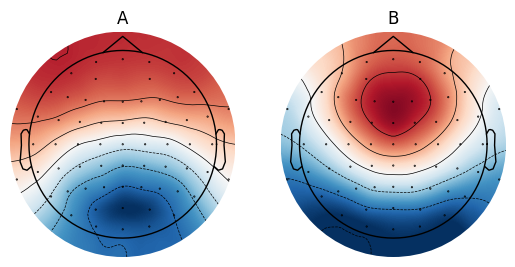

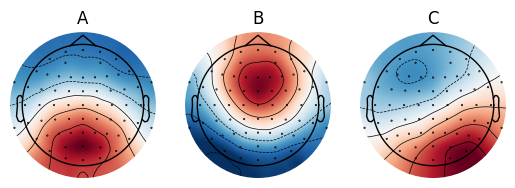

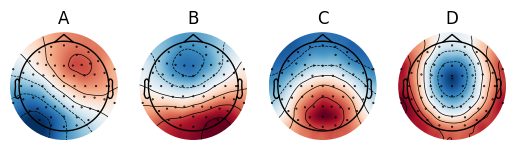

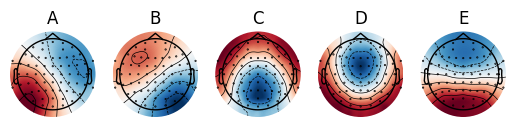

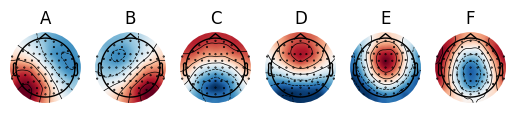

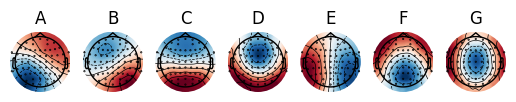

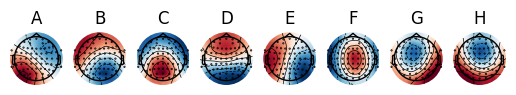

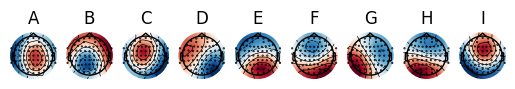

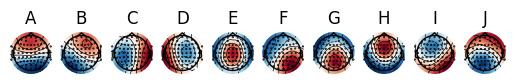

In [118]:
for tmp_mod in models:
    tmp_mod.plot()
    plt.show()

# Show stats

In [119]:
n_clusters = 7
stats = pd.read_csv(folder_statistics+f'stats_k_{n_clusters}.csv')

In [120]:
### Rename microstates
# Mapping from numbers to letters
#number_to_letter = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H'}

number_to_letter = {}

for tmp_idx in range(n_clusters):
    number_to_letter.update({reorder[n_clusters-2][tmp_idx]: list(string.ascii_uppercase)[tmp_idx]})
    
# Apply the mapping to the specified column
stats['state_name'] = stats['microstate'].map(number_to_letter)

In [122]:
stats

,subject,task,microstate,mean_corr,gev,timecov,meandurs,occurrences,state_name
0,1,REST,0,0.870735,0.024084,0.178077,0.012327,14.446073,C
1,1,REST,1,0.778606,0.007777,0.137575,0.010645,12.924460,A
2,1,REST,2,0.786115,0.007149,0.137323,0.010173,13.498304,F
3,1,REST,3,0.808380,0.013150,0.181128,0.011835,15.304989,D
4,1,REST,4,0.684876,0.002850,0.100819,0.008844,11.399144,E
...,...,...,...,...,...,...,...,...,...
2151,44,S 72,2,0.841195,0.002905,0.215708,0.015505,13.911996,F
2152,44,S 72,3,0.818453,0.001283,0.143996,0.012126,11.875394,D
2153,44,S 72,4,0.697126,0.000336,0.080087,0.010043,7.974299,E
2154,44,S 72,5,0.768053,0.001132,0.160748,0.012412,12.951064,G


In [128]:
stats.to_csv(folder_statistics+f'stats_renamed_k_{n_clusters}.csv', index=False)

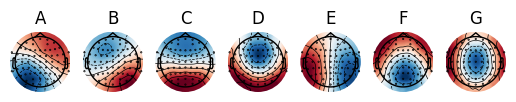

In [124]:
#plt.figure(figsize=(8,4))
#ax=plt.subplot(1,1,1)
models[n_clusters-2].plot()
plt.show()

In [177]:
### Compute deltas
probs_rest = stats.loc[stats['task']=='REST'].drop(columns=['mean_corr', 'gev', 'meandurs', 'occurrences'])
probs_task = stats.loc[stats['task']!='REST'].drop(columns=['mean_corr', 'gev', 'meandurs', 'occurrences'])
deltas = probs_task.copy()

deltas_values = []

for subj in subjects:
    tmp_p_rest = probs_rest.loc[probs_rest['subject']==subj]['timecov'].values
    tmp_p_task = probs_task.loc[probs_task['subject']==subj]
    
    tmp_delta = []
    
    for tmp_task in tasks[1:]:
        tmp_delta.append(tmp_p_task.loc[tmp_p_task['task']==tmp_task]['timecov'].values-tmp_p_rest)
        
    deltas_values.append(tmp_delta)
        
deltas_values = np.array(deltas_values).flatten()
deltas.insert(4, 'delta', deltas_values)

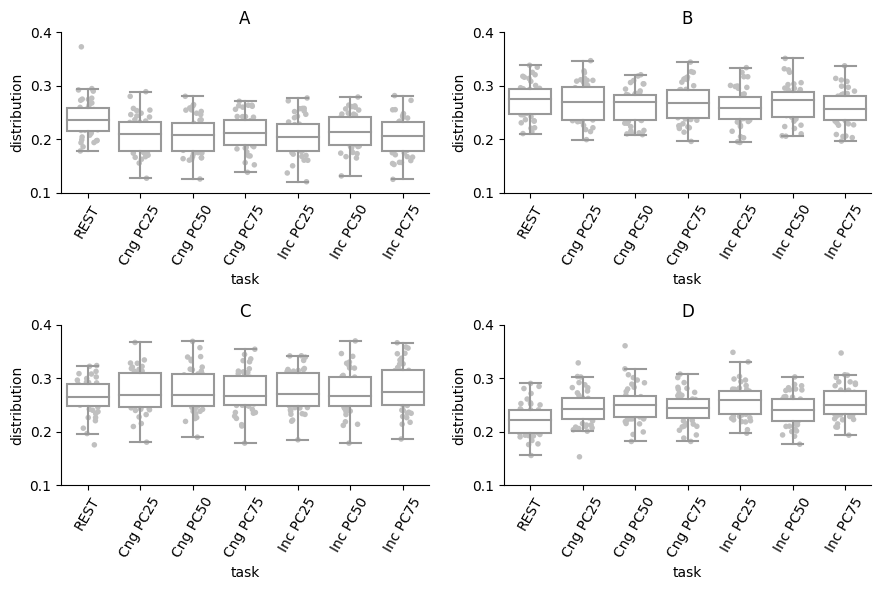

In [115]:
order = None

plt.figure(figsize=(9,6))

for tmp_idx, state in enumerate(reorder[n_clusters-2]):
    data = stats.loc[stats['microstate']==state]
    x = 'task'
    y = 'timecov'

    ax = plt.subplot(2,2,tmp_idx+1)
    sns.boxplot(data=data, x=x, y=y, color='1', order=order, showfliers = False, ax=ax)
    sns.stripplot(data=data, x=x, y=y, order=order, color="silver", jitter=0.2, zorder=0, size=4, ax=ax)
    ax.set_xticklabels(["REST","Cng PC25", "Cng PC50", "Cng PC75","Inc PC25", "Inc PC50", "Inc PC75"], rotation=60)
    plt.ylabel('distribution')
    plt.ylim(0.1, 0.4)
    
    plt.title(list(string.ascii_uppercase)[tmp_idx])
    
plt.tight_layout()
sns.despine()
plt.show()

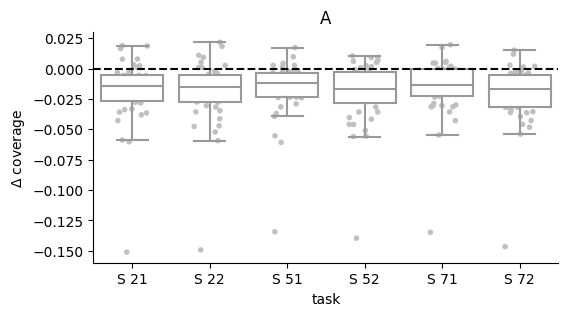

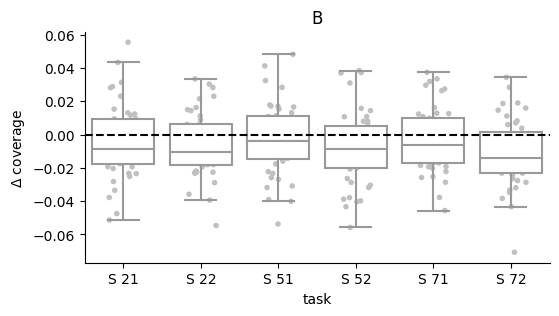

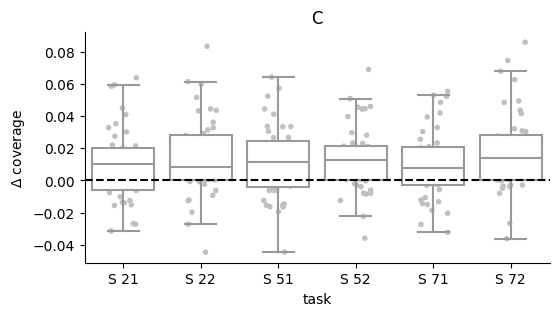

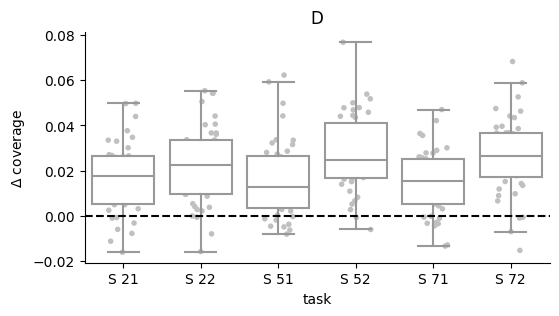

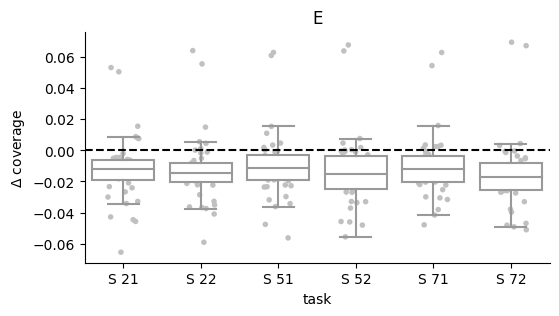

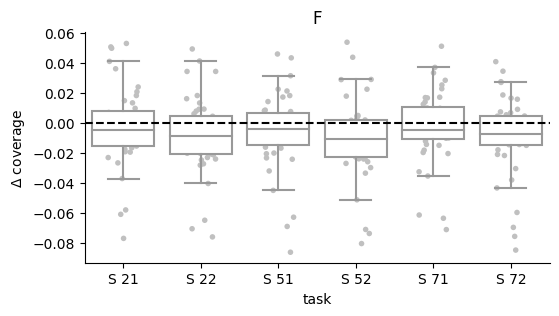

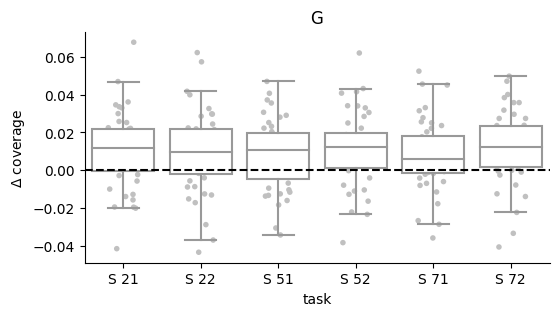

In [143]:
order = None

for tmp_idx, state in enumerate(reorder[n_clusters-2]):
    data = deltas.loc[deltas['microstate']==state]
    x = 'task'
    y = 'delta'
    ylabel = r'$\Delta$ coverage'

    plt.figure(figsize=(6,3))
    sns.boxplot(data=data, x=x, y=y, color='1', order=order, showfliers = False)
    sns.stripplot(data=data, x=x, y=y, order=order, color="silver", jitter=0.2, zorder=0, size=4)
    plt.axhline(0, c='k', ls='--')
    
    plt.ylabel(ylabel)
    #plt.ylim(None, 0.10)
    
    plt.title(list(string.ascii_uppercase)[tmp_idx])
    
    sns.despine()
    plt.show()

# Show entropy rate

In [71]:
n_clusters = 7
stats = pd.read_csv(folder_statistics+f'ent_rate_k_{n_clusters}.csv')

In [74]:
stats

,subject,task,ent_rate
0,1,REST,1.509462
1,1,S 21,1.319537
2,1,S 22,1.433572
3,1,S 51,1.284059
4,1,S 52,1.292088
...,...,...,...
303,44,S 22,1.376418
304,44,S 51,1.228236
305,44,S 52,1.235726
306,44,S 71,1.367713


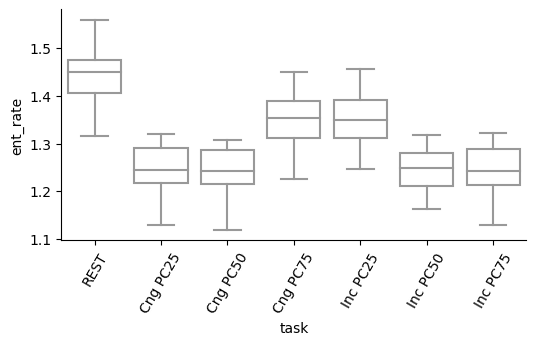

In [95]:
plt.figure(figsize=(6,3))

order = ['REST', 'S 21', 'S 51', 'S 71', 'S 22', 'S 52', 'S 72']

x = 'task'
y = 'ent_rate'
ax = sns.boxplot(data=stats, x=x, y=y, color='1', order=order, showfliers = False)
sns.despine()
ax.set_xticklabels(["REST","Cng PC25", "Cng PC50", "Cng PC75","Inc PC25", "Inc PC50", "Inc PC75"], rotation=60)
plt.show()

# Compute control cost

In [6]:
import ot

# Define utils
def KL(a, b):
    tmp = a * ( np.log(a) - np.log(b) )
    tmp[np.isnan(tmp)] = 0
    tmp[np.isinf(tmp)] = 0
    return tmp.sum()

def f(G):
    return np.sum(G * np.log(G))

def df(G):
    return np.log(G) + 1.

2024-07-16 19:16:05.288133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-16 19:16:06.543017: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-07-16 19:16:06.543144: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-07-16 19:16:06.543153: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

In [10]:
eps = 1

costs = [[] for _ in cluster_range]

### Loop over clusters
for idx_clust, n_clusters in enumerate(cluster_range):
    print(f'K={n_clusters}')
    
    ### Load stats
    stats = pd.read_csv(folder_statistics+f'stats_k_{n_clusters}.csv')
    
    ### Load transition matrix
    tmats = np.load(folder_statistics+f'tmats_k_{n_clusters}.npy')
    
    ### Loop over subjects
    print('Computing cost...')
    for idx_subject, subject_id in enumerate(subjects):
        ### Get subject data
        stats_subj = stats.loc[stats['subject']==subject_id]
        # Keep only timecov
        stats_subj = stats_subj[['task', 'microstate', 'timecov']]
        # Keep only transition matrix at rest
        Qij = tmats[idx_subject*len(tasks)].T
        Qij = Qij / Qij.sum()
        Qij = Qij.T
        # Get resting pdf
        pdf_rest = stats_subj.loc[stats_subj['task']=='REST']['timecov'].values
        
        ### Create cost matrix
        cost_matrix = -np.log(Qij)
        # Handle infinities
        cost_matrix[np.isinf(cost_matrix)] = 1e10
        
        ### Compute cost for each task
        cost_subj = np.zeros(len(tasks)-1)
        kl_subj = np.zeros(len(tasks)-1)
        for idx_task, task in enumerate(tasks[1:]):
            # Get task pdf
            pdf_task = stats_subj.loc[stats_subj['task']==task]['timecov'].values
            
            # Compute OT problem
            Pij = ot.optim.cg(pdf_rest, pdf_task, cost_matrix, eps, f, df, verbose=False)
        
            # Compute cost
            cost = KL(Pij, Qij)
            
            # Store cost
            cost_subj[idx_task] = cost
            
            # Compute KL divergence
            kl_subj[idx_task] = KL(pdf_task, pdf_rest)
        
        # Store cost
        tmp_df = pd.DataFrame(cost_subj, columns=['cost'])
        tmp_df.insert(0,'task',tasks[1:])
        tmp_df.insert(0,'subject',subject_id)
        tmp_df['kl'] = kl_subj
        costs[idx_clust].append(tmp_df)
        
### Concatenate costs
costs = [pd.concat(tmp) for tmp in costs]

ctrl = ['H', 'H', 'M', 'M', 'L', 'L']
#ctrl = ['H', 'L', 'M', 'M', 'L', 'H']
cong = ['C', 'I', 'C', 'I', 'C', 'I']

[tmp.insert(2, 'ctrl', ctrl * n_subj) for tmp in costs]
[tmp.insert(3, 'cong', cong * n_subj) for tmp in costs]

K=2
Computing cost...
K=3
Computing cost...
K=4
Computing cost...
K=5
Computing cost...
K=6
Computing cost...
K=7
Computing cost...
K=8
Computing cost...
K=9
Computing cost...
K=10
Computing cost...


[None, None, None, None, None, None, None, None, None]

K=2


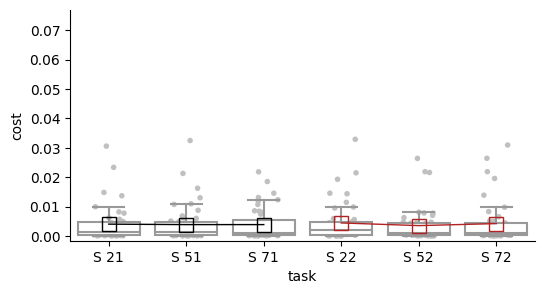

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  0.0344 2.0000 86.0000 0.9662

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  1.5010 2.0000 86.0000 0.2287

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  0.5871 2.0000 86.0000 0.5582

K=3


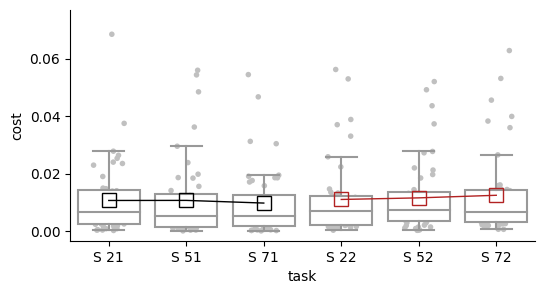

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  0.4339 2.0000 86.0000 0.6494

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  1.3198 2.0000 86.0000 0.2725

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  1.7660 2.0000 86.0000 0.1772

K=4


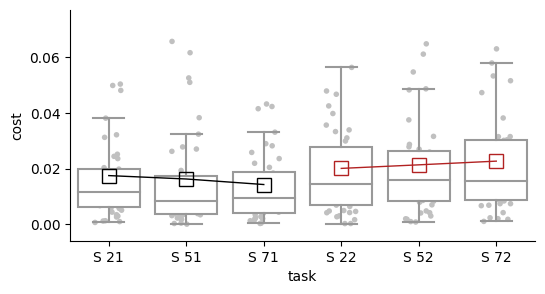

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  3.4683 2.0000 86.0000 0.0356

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  1.6189 2.0000 86.0000 0.2041

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  6.9775 2.0000 86.0000 0.0016

K=5


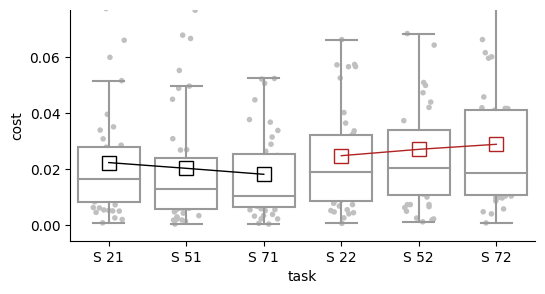

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  3.9501 2.0000 86.0000 0.0228

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  2.6053 2.0000 86.0000 0.0797

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  9.0271 2.0000 86.0000 0.0003

K=6


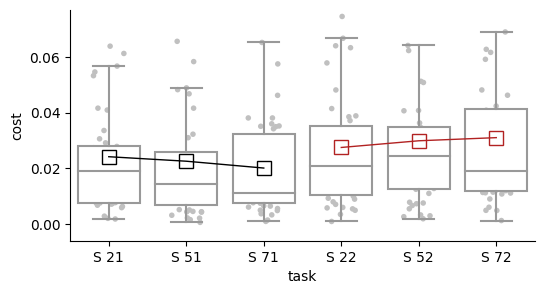

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  3.2312 2.0000 86.0000 0.0444

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  1.9522 2.0000 86.0000 0.1482

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  7.5020 2.0000 86.0000 0.0010

K=7


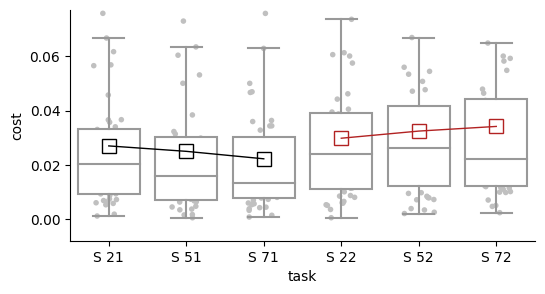

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  3.8701 2.0000 86.0000 0.0246

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  2.7722 2.0000 86.0000 0.0681

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  9.9657 2.0000 86.0000 0.0001

K=8


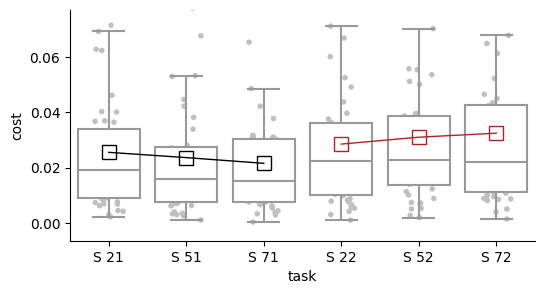

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  3.7384 2.0000 86.0000 0.0277

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  2.2741 2.0000 86.0000 0.1090

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  8.1883 2.0000 86.0000 0.0006

K=9


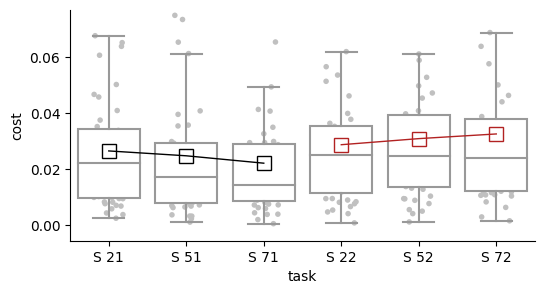

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  3.8944 2.0000 86.0000 0.0240

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  2.2955 2.0000 86.0000 0.1068

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  8.8186 2.0000 86.0000 0.0003

K=10


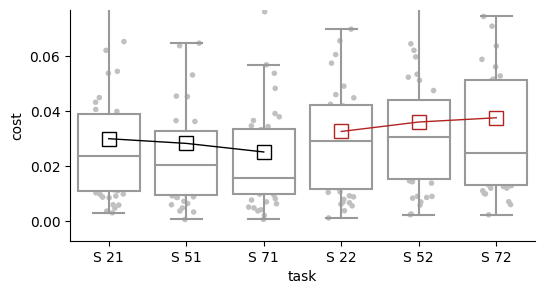

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  3.2872 2.0000 86.0000 0.0421

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  3.2152 2.0000 86.0000 0.0450

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  9.3402 2.0000 86.0000 0.0002



In [160]:
order = np.array([0,2,4,1,3,5]).astype(int) +1
order = np.array(tasks)[order]

for idx_clust, n_clusters in enumerate(cluster_range):
    print(f'K={n_clusters}')
    
    ### Extract data
    data = costs[idx_clust]
    x = 'task'
    y = 'cost'
    
    data_cong = data.loc[data['cong']=='C']
    mean_cong = data_cong.groupby('ctrl').mean()
    mean_cong = mean_cong['cost'].values[[0,2,1]]

    data_inc = data.loc[data['cong']=='I']
    mean_inc = data_inc.groupby('ctrl').mean()
    mean_inc = mean_inc['cost'].values[[0,2,1]]

    ### Boxplot
    plt.figure(figsize=(6,3))
    sns.boxplot(data=data, x=x, y=y, color='1', order=order, showfliers = False)
    sns.stripplot(data=data, x=x, y=y, order=order, color="silver", jitter=0.2, zorder=0, size=4)
    
    # Add pointplot
    lw = 1
    ls = '-'
    marker = 's'
    ms = 10
    plt.plot(np.arange(3), mean_cong, lw=lw, zorder=10, ls=ls, marker=marker, ms=ms, c='k', markerfacecolor="None")
    plt.plot(np.arange(3)+3, mean_inc, lw=lw, zorder=10, ls=ls, marker=marker, ms=ms, c='firebrick', markerfacecolor="None")

    
    plt.ylim(None, 0.077)
    
    sns.despine()
    plt.show()
    
    ### Compute anova for C
    print('Congruent')
    tmp_cost_cong = data.loc[data['cong']=='C'].drop(columns=['task'])
    
    arm = AnovaRM(data=tmp_cost_cong, depvar='cost', subject='subject', within=['ctrl'])
    arm = arm.fit()
    print(arm.summary())
    
    ### Compute anova for I
    print('Incongruent')
    tmp_cost_inc = data.loc[data['cong']=='I'].drop(columns=['task'])
    
    arm = AnovaRM(data=tmp_cost_inc, depvar='cost', subject='subject', within=['ctrl'])
    arm = arm.fit()
    print(arm.summary())
    
    ### Compute STROOP effect
    print('Stroop')
    delta = tmp_cost_inc.copy()
    delta['delta_cost'] = tmp_cost_inc['cost'].values - tmp_cost_cong['cost'].values
    delta = delta.drop(columns=['cong'])
    
    arm = AnovaRM(data=delta, depvar='delta_cost', subject='subject', within=['ctrl'])
    arm = arm.fit()
    print(arm.summary())

K=2


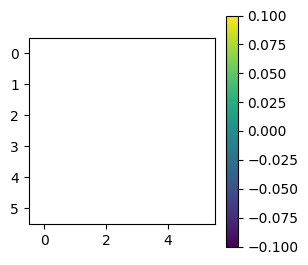

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cong       0.0969 1.0000 43.0000 0.7571
ctrl       0.6093 2.0000 86.0000 0.5461
cong:ctrl  0.5871 2.0000 86.0000 0.5582

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cong  0.0969 1.0000 43.0000 0.7571

K=3


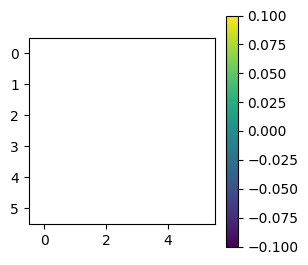

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cong       2.1385 1.0000 43.0000 0.1509
ctrl       0.0867 2.0000 86.0000 0.9171
cong:ctrl  1.7660 2.0000 86.0000 0.1772

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cong  2.1385 1.0000 43.0000 0.1509

K=4


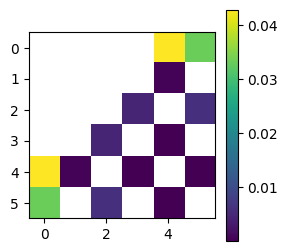

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cong      24.4607 1.0000 43.0000 0.0000
ctrl       0.0561 2.0000 86.0000 0.9455
cong:ctrl  6.9775 2.0000 86.0000 0.0016

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cong 24.4607 1.0000 43.0000 0.0000

K=5


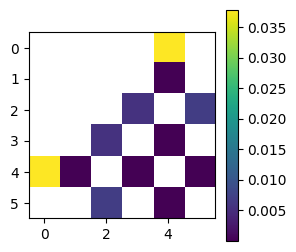

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cong      21.7969 1.0000 43.0000 0.0000
ctrl       0.0079 2.0000 86.0000 0.9921
cong:ctrl  9.0271 2.0000 86.0000 0.0003

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cong 21.7969 1.0000 43.0000 0.0000

K=6


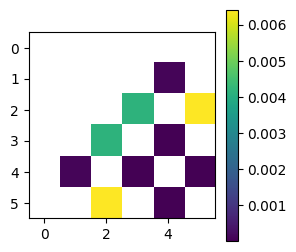

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cong      25.8149 1.0000 43.0000 0.0000
ctrl       0.1115 2.0000 86.0000 0.8946
cong:ctrl  7.5020 2.0000 86.0000 0.0010

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cong 25.8149 1.0000 43.0000 0.0000

K=7


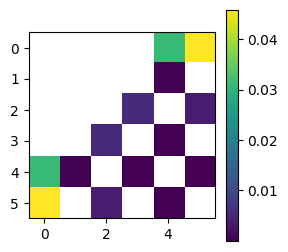

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cong      24.8767 1.0000 43.0000 0.0000
ctrl       0.0627 2.0000 86.0000 0.9393
cong:ctrl  9.9657 2.0000 86.0000 0.0001

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cong 24.8767 1.0000 43.0000 0.0000

K=8


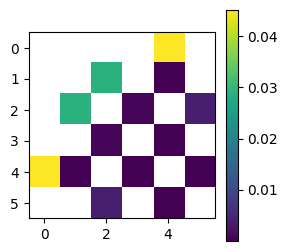

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cong      25.1835 1.0000 43.0000 0.0000
ctrl       0.0330 2.0000 86.0000 0.9675
cong:ctrl  8.1883 2.0000 86.0000 0.0006

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cong 25.1835 1.0000 43.0000 0.0000

K=9


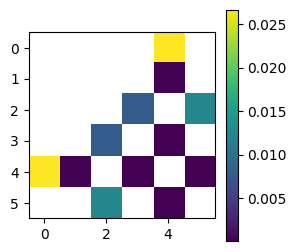

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cong      18.7647 1.0000 43.0000 0.0001
ctrl       0.0620 2.0000 86.0000 0.9400
cong:ctrl  8.8186 2.0000 86.0000 0.0003

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cong 18.7647 1.0000 43.0000 0.0001

K=10


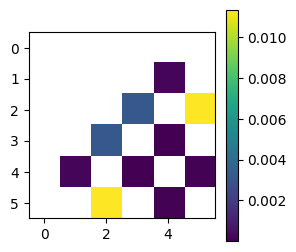

                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
cong      21.8781 1.0000 43.0000 0.0000
ctrl       0.1800 2.0000 86.0000 0.8356
cong:ctrl  9.3402 2.0000 86.0000 0.0002

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
cong 21.8781 1.0000 43.0000 0.0000



In [155]:
for idx_clust, n_clusters in enumerate(cluster_range):
    print(f'K={n_clusters}')
    
    tmp_costs = costs[idx_clust]
    
    p_vals = np.zeros((len(tasks)-1,len(tasks)-1))
    
    for idx_task_i, task_i in enumerate(tasks[1:]):
        data_i = tmp_costs.loc[tmp_costs['task']==task_i]['cost'].values
        
        for idx_task_j, task_j in enumerate(tasks[1:]):
            data_j = tmp_costs.loc[tmp_costs['task']==task_j]['cost'].values
            
            p_vals[idx_task_i, idx_task_j] = ttest_rel(data_i, data_j)[1]
            
            
    p_vals = p_vals * ( len(tasks) -1)
    p_vals[p_vals>0.05] = np.nan
            
    plt.figure(figsize=(3,3))
    plt.imshow(p_vals)
    plt.colorbar()
    plt.show()
    
    ### Anova repeated measures
    tmp_costs = tmp_costs.drop(columns=['task'])
    arm = AnovaRM(data=tmp_costs, depvar='cost', subject='subject', within=['cong','ctrl'])
    arm = arm.fit()
    print(arm.summary())
    
    tmp_costs = tmp_costs.drop(columns=['ctrl'])
    arm = AnovaRM(data=tmp_costs, depvar='cost', subject='subject', within=['cong'], aggregate_func='mean')
    arm = arm.fit()
    print(arm.summary())

# Compute KL divergence

K=2


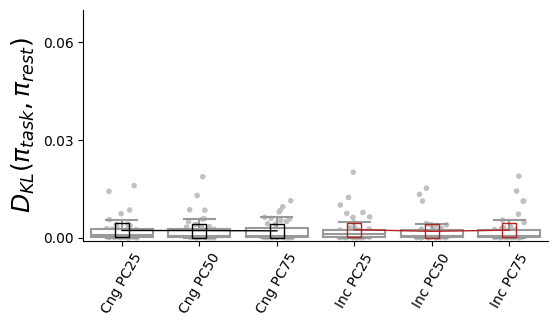

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  0.0451 2.0000 86.0000 0.9560

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  1.4680 2.0000 86.0000 0.2361

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  0.7597 2.0000 86.0000 0.4709

K=3


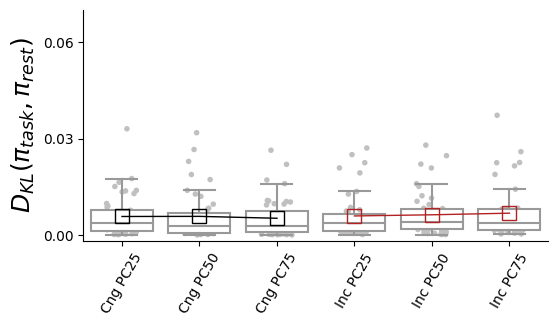

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  0.5596 2.0000 86.0000 0.5735

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  1.4559 2.0000 86.0000 0.2389

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  1.9976 2.0000 86.0000 0.1419

K=4


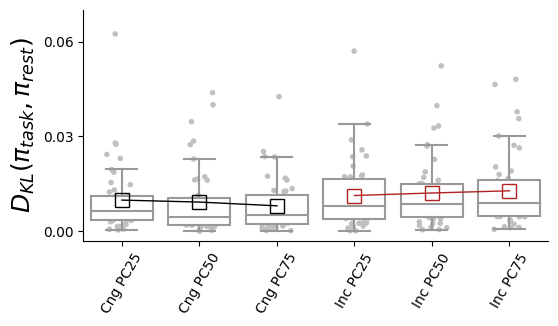

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  3.4847 2.0000 86.0000 0.0351

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  1.6721 2.0000 86.0000 0.1939

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  6.8861 2.0000 86.0000 0.0017

K=5


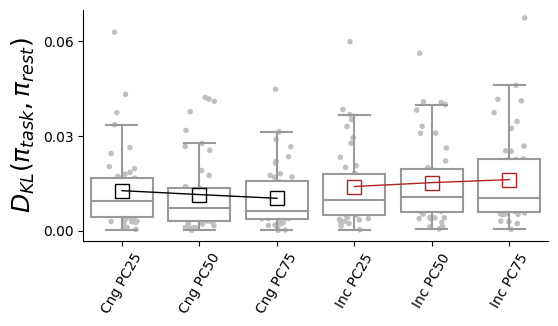

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  4.2073 2.0000 86.0000 0.0181

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  2.4060 2.0000 86.0000 0.0962

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  8.7942 2.0000 86.0000 0.0003

K=6


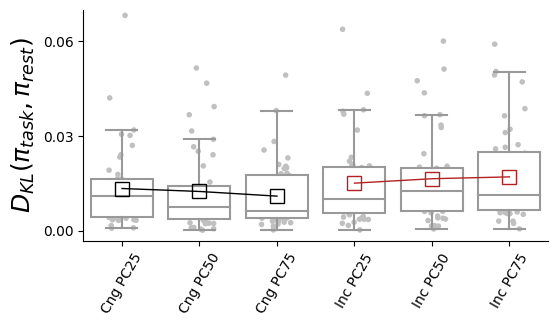

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  3.6899 2.0000 86.0000 0.0290

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  2.0631 2.0000 86.0000 0.1333

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  8.1531 2.0000 86.0000 0.0006

K=7


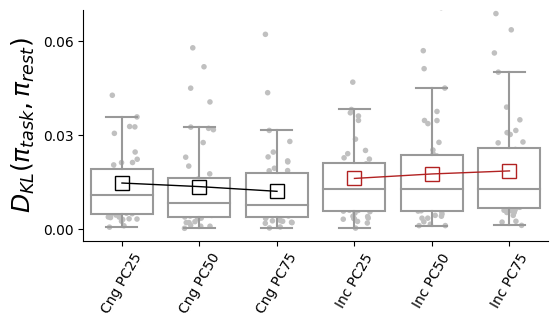

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  4.2635 2.0000 86.0000 0.0172

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  2.8399 2.0000 86.0000 0.0639

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl 10.4138 2.0000 86.0000 0.0001

K=8


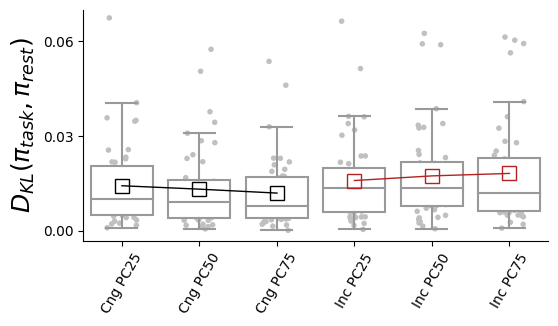

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  4.0260 2.0000 86.0000 0.0213

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  2.4254 2.0000 86.0000 0.0945

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  8.5046 2.0000 86.0000 0.0004

K=9


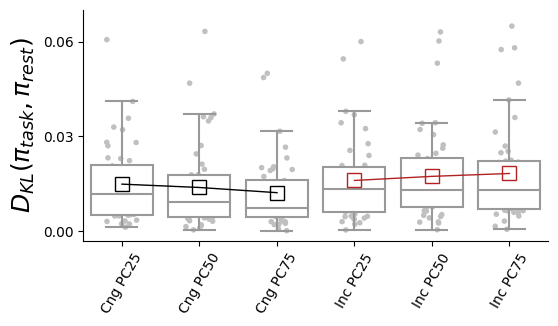

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  4.5550 2.0000 86.0000 0.0132

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  2.4582 2.0000 86.0000 0.0916

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  9.6795 2.0000 86.0000 0.0002

K=10


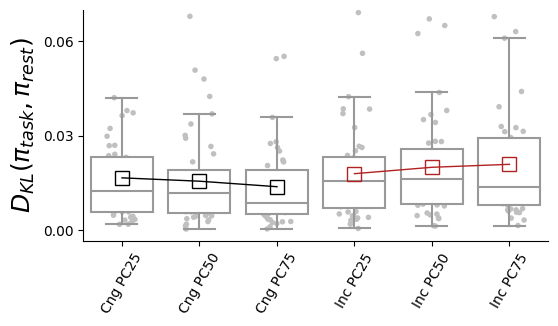

Congruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  3.7057 2.0000 86.0000 0.0286

Incongruent
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl  3.7450 2.0000 86.0000 0.0276

Stroop
              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
ctrl 10.3577 2.0000 86.0000 0.0001



In [15]:
order = np.array([0,2,4,1,3,5]).astype(int) +1
order = np.array(tasks)[order]

for idx_clust, n_clusters in enumerate(cluster_range):
    print(f'K={n_clusters}')
    
    ### Extract data
    data = costs[idx_clust]
    x = 'task'
    y = 'kl'
    
    data_cong = data.loc[data['cong']=='C']
    mean_cong = data_cong.groupby('ctrl').mean()
    mean_cong = mean_cong[y].values[[0,2,1]]

    data_inc = data.loc[data['cong']=='I']
    mean_inc = data_inc.groupby('ctrl').mean()
    mean_inc = mean_inc[y].values[[0,2,1]]

    ### Boxplot
    plt.figure(figsize=(6,3))
    ax = sns.boxplot(data=data, x=x, y=y, color='1', order=order, showfliers = False)
    sns.stripplot(data=data, x=x, y=y, order=order, color="silver", jitter=0.2, zorder=0, size=4, ax=ax)
    ax.set_xticklabels(["Cng PC25", "Cng PC50", "Cng PC75","Inc PC25", "Inc PC50", "Inc PC75"], rotation=60)
    
    # Add pointplot
    lw = 1
    ls = '-'
    marker = 's'
    ms = 10
    plt.plot(np.arange(3), mean_cong, lw=lw, zorder=10, ls=ls, marker=marker, ms=ms, c='k', markerfacecolor="None")
    plt.plot(np.arange(3)+3, mean_inc, lw=lw, zorder=10, ls=ls, marker=marker, ms=ms, c='firebrick', markerfacecolor="None")
    
    plt.ylim(None, 0.07)
    plt.yticks([0, 0.03, 0.06])
    
    plt.ylabel('$D_{KL} (\pi_{task}, \pi_{rest})$', size=18)
    plt.xlabel('')
    
    sns.despine()
    plt.show()
    
    ### Compute anova for C
    print('Congruent')
    tmp_cost_cong = data.loc[data['cong']=='C'].drop(columns=['task'])
    
    arm = AnovaRM(data=tmp_cost_cong, depvar=y, subject='subject', within=['ctrl'])
    arm = arm.fit()
    print(arm.summary())
    
    ### Compute anova for I
    print('Incongruent')
    tmp_cost_inc = data.loc[data['cong']=='I'].drop(columns=['task'])
    
    arm = AnovaRM(data=tmp_cost_inc, depvar=y, subject='subject', within=['ctrl'])
    arm = arm.fit()
    print(arm.summary())
    
    ### Compute STROOP effect
    print('Stroop')
    delta = tmp_cost_inc.copy()
    delta['delta_kl'] = tmp_cost_inc[y].values - tmp_cost_cong[y].values
    delta = delta.drop(columns=['cong'])
    
    arm = AnovaRM(data=delta, depvar='delta_kl', subject='subject', within=['ctrl'])
    arm = arm.fit()
    print(arm.summary())

In [16]:
### Add RT
n_clusters = 7

rt = np.load('results/rt.npy')

tmp_data = costs[n_clusters-2]

order_rt = [0,3,1,4,2,5]
tmp_data['rt'] = rt[:,[order_rt]].flatten()

tmp_data.to_csv(folder_statistics+f'cost_rt_k_{n_clusters}.csv', index=False)

In [17]:
n_clusters = 7
tmp_data= pd.read_csv(folder_statistics+f'cost_rt_k_{n_clusters}.csv')

In [18]:
tmp_data

,subject,task,ctrl,cong,cost,kl,rt
0,1,S 21,H,C,0.031126,0.018804,0.931947
1,1,S 22,H,I,0.057419,0.034719,0.905973
2,1,S 51,M,C,0.038370,0.022965,0.912757
3,1,S 52,M,I,0.055881,0.033690,1.023676
4,1,S 71,L,C,0.029107,0.017539,0.884311
...,...,...,...,...,...,...,...
259,44,S 22,H,I,0.026813,0.016363,0.933224
260,44,S 51,M,C,0.021124,0.012889,0.841730
261,44,S 52,M,I,0.039961,0.024042,0.994919
262,44,S 71,L,C,0.017591,0.010743,0.825680


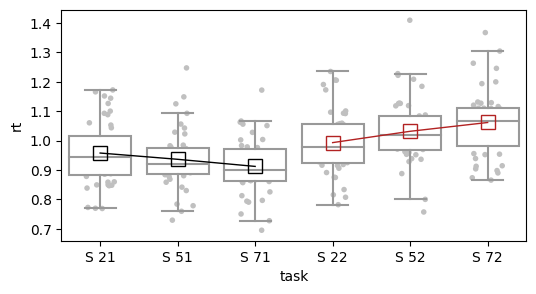

In [48]:
order = np.array([0,2,4,1,3,5]).astype(int) +1
order = np.array(tasks)[order]

if True:
    ### Extract data
    data = tmp_data
    x = 'task'
    y = 'rt'
    
    data_cong = data.loc[data['cong']=='C']
    mean_cong = data_cong.groupby('ctrl').mean()
    mean_cong = mean_cong[y].values[[0,2,1]]

    data_inc = data.loc[data['cong']=='I']
    mean_inc = data_inc.groupby('ctrl').mean()
    mean_inc = mean_inc[y].values[[0,2,1]]

    ### Boxplot
    plt.figure(figsize=(6,3))
    sns.boxplot(data=data, x=x, y=y, color='1', order=order, showfliers = False)
    sns.stripplot(data=data, x=x, y=y, order=order, color="silver", jitter=0.2, zorder=0, size=4)
    
    # Add pointplot
    lw = 1
    ls = '-'
    marker = 's'
    ms = 10
    plt.plot(np.arange(3), mean_cong, lw=lw, zorder=10, ls=ls, marker=marker, ms=ms, c='k', markerfacecolor="None")
    plt.plot(np.arange(3)+3, mean_inc, lw=lw, zorder=10, ls=ls, marker=marker, ms=ms, c='firebrick', markerfacecolor="None")

    